In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import motrack
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [7]:
motrack.track_motion("videos/test.avi",remove_bg = True, reinitialize = False)

End of stream


In [211]:
pts = np.array([[1259,  520],
               [1259,  626],
               [1434,  626],
               [1434,  520]], dtype = np.int32)
frame = cv2.imread('videos/frame.png')
background, mask_fgd = motrack.segment_background(frame, pts)

In [127]:
frame = motrack.subtract_background(frame, background, [])

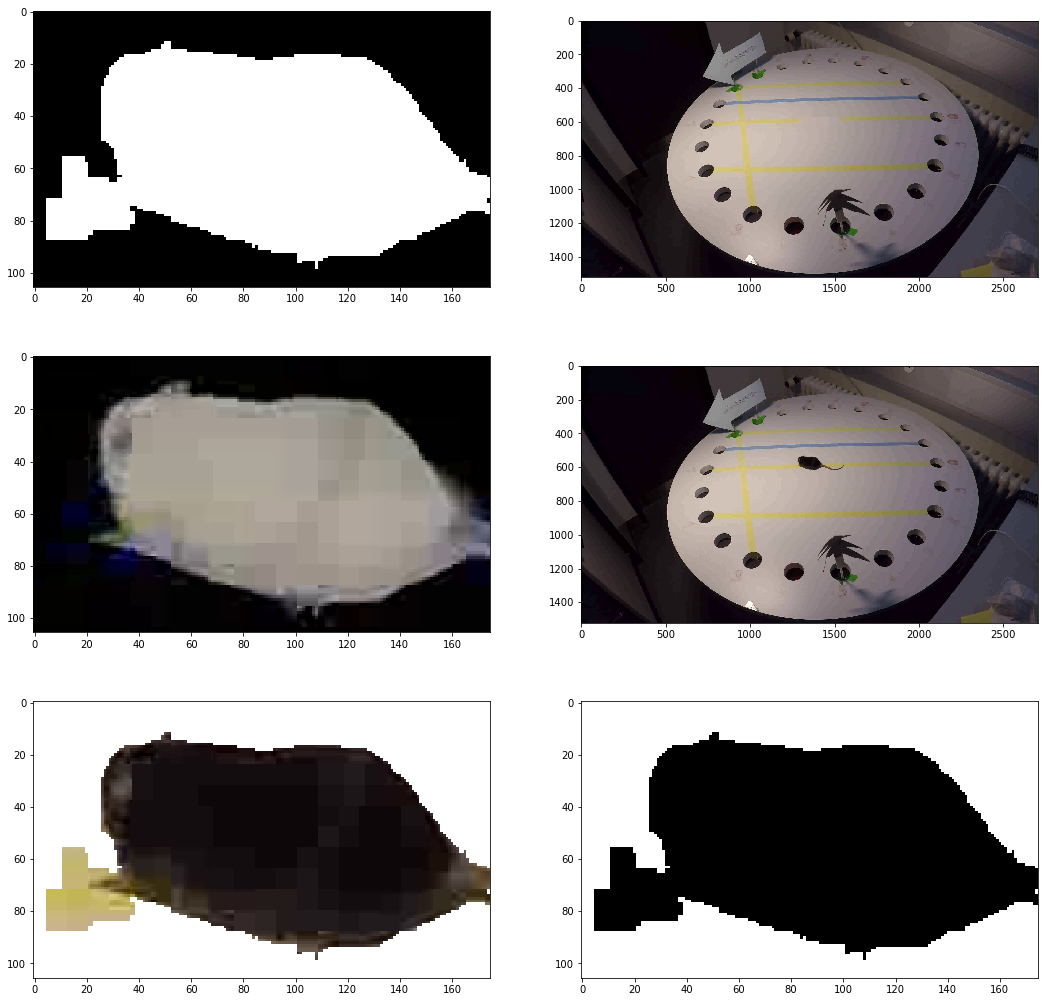

In [238]:
mask_bgd = np.invert(mask_fgd, dtype = np.uint8)
frame_sub1 = cv2.subtract(background, frame, mask = mask_bgd)

#frame_sub2 = cv2.bitwise_and(frame, background, mask = mask_bgd)
#frame_sub2[mask_fgd == 0] = np.abs(background - frame)[mask_fgd == 0]

frame_sub3 = frame.copy()
frame_sub3[mask_fgd == 0,:] = np.ones_like(frame,dtype=np.uint8)[mask_fgd == 0,:]*255

#frame_sub = cv2.absdiff(background, frame)
#frame_sub = cv2.cvtColor(frame_sub, cv2.COLOR_BGR2GRAY)
#frame_sub = frame_sub > 0
# cv2.normalize(  frame_sub1, frame_sub1,
#                  alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX,
#                  dtype=cv2.CV_8U)

fig, ax = plt.subplots(3, 2, figsize = (18, 18))

ax[0,0].imshow(mask_fgd[pts[0][0]:pts[1][0], pts[0][1]:pts[2][1]],cmap="gray")
ax[0,1].imshow(background,cmap="gray")
ax[1,0].imshow(frame_sub1[pts[0][0]:pts[1][0], pts[0][1]:pts[2][1],:],cmap="gray")
ax[1,1].imshow(frame,cmap="gray")
ax[2,0].imshow(frame_sub3[pts[0][0]:pts[1][0], pts[0][1]:pts[2][1],:],cmap="gray")
ax[2,1].imshow(mask_bgd[pts[0][0]:pts[1][0], pts[0][1]:pts[2][1]],cmap="gray")
plt.show()

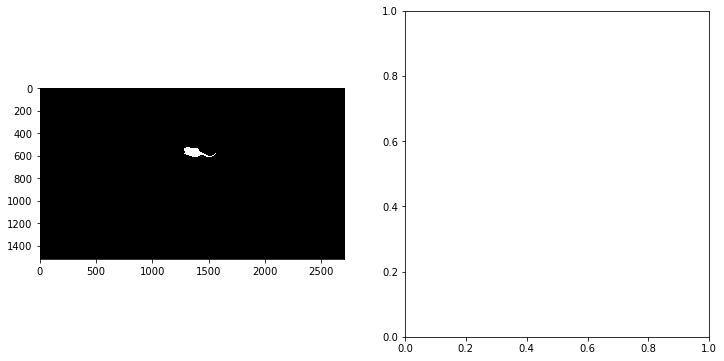

(1520, 2704)

In [21]:
frame_avg = cv2.imread('videos/frame_avg.png')
(vis_image, _) = motrack.label_contours(frame_avg, (3,3), 1, (5,5))
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
ax1.imshow(vis_image, cmap = 'bone')
#ax2.imshow(, cmap = 'bone')
plt.show()
vis_image.shape

In [76]:
import scikit-learn

SyntaxError: invalid syntax (<ipython-input-76-fb00d79688a4>, line 1)

#### Next you need to:
    - Make the search more robust (try different hardcoded values, some more filtering, ...)
    - Have one function for the same part of algorithm, but pass different flags to have different aproaches

    Code graveyrard, to be deleted once things are working:
    

In [ ]:
#     s_size = hsv_upperb[1] - hsv_lowerb[1]
#     v_size = hsv_upperb[2] - hsv_lowerb[2]
#     s_range = np.arange(hsv_lowerb[1], hsv_upperb[1] + 1).tolist()
#     v_range = np.arange(hsv_lowerb[2], hsv_upperb[2] + 1).tolist()
#     # h_ranges = [[s_range], [v_range]]
#     h_sizes =  [s_size, v_size]
#     h_ranges = [hsv_lowerb[1], hsv_upperb[1], hsv_lowerb[2], hsv_upperb[2]]

# Draw bbox on the average image
# p1 = (int(bbox[0]), int(bbox[1]))
# p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
# frame_avg = cv2.rectangle(frame_avg, p1, p2, color = red)

In [ ]:
def label_thresh(frame_avg, bbox, pad):
    """Find binary image of object of interest
    
    Facilitate object tracking by first thresholding roi and then creating
    a binary mask. Currently not used.
    
    Parameters
    ----------
    pad : int
        Optinally specifies number of pixel to be added on each side of 
        the bounding box
    bbox : tuple
        (minY, minX, deltaY, deltaX)
    Returns
    ----------
    
    """
    frame_avg_gray = cv2.cvtColor(frame_avg, cv2.COLOR_BGR2GRAY)
    frame_avg_gray = cv2.GaussianBlur(frame_avg_gray, kSize, sigmaX)
    frame_roi = frame_avg_gray[int(bbox[1] - pad) : int(bbox[1] + bbox[3] + pad),
                               int(bbox[0] - pad) : int(bbox[0] + bbox[2] + pad)]
    # Aply Automatic threshold
    thresh = threshold_otsu(frame_roi);
    binary = frame_roi < thresh # May need to change sign for different img
    selem = diamond(10) 
    binary_cl = binary_closing(binary, selem)
    # Create mask where we will put our thresholded object
    mask = np.zeros_like(frame_avg_gray, dtype = np.uint8)
    # Put the boundig box into the mask
    mask[   int(bbox[1] - pad) : int(bbox[1] + bbox[3] + pad),
            int(bbox[0] - pad) : int(bbox[0] + bbox[2] + pad)] = binary_cl
    # Label connected components
    binary_label = label(mask)
    # Extract location of centroid and bbox of the thresholded object
    binary_props = regionprops(binary_label)
    cent=(int(binary_props[0].centroid[0]), int(binary_props[0].centroid[1]))       
    bboxRP = binary_props[0].bbox
    # We need to shuffle the dimensions quite a bit
    bbox = (bboxRP[1], bboxRP[0], int(bboxRP[3] - bboxRP[1]), int(bboxRP[2] - bboxRP[0]))
    return bbox, mask, frame_avg_gray